<center>
    <h1>ADRL Assignment 1</h1>
    <h2>Generative Adversarial Networks</h2>
    <h3>Team Members</h3>
    <ul>
        <li>*Gouri Shanker*</li>
        <li>*Abhay Patidar*</li>
        <li>*Shreeman Aggarwal*</li>
    </ul>
</center>

## Question 1 : Training DC GAN 

### imports

In [ ]:

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,ConcatDataset,Dataset
from torchvision import  datasets, transforms
import torchvision.utils as vutils

import cv2, numpy as np, pandas as pd
import random
import matplotlib.pyplot as plt
import os

In [ ]:
# Class for Runtime Augmentation of Images

class AdaptiveAugmentation:
    def __init__(self, initial_prob=0.5, max_prob=0.8, adapt_rate=0.001):
        self.prob = initial_prob
        self.max_prob = max_prob
        self.adapt_rate = adapt_rate
        self.groups = 4
        
            
    @staticmethod         
    def inc_brightness( images):
        amount = random.uniform(0.1, 0.3)
        t1 = images + amount
        t1 = t1.clip(-1, 1)
        return t1
    
    @staticmethod
    def dec_brightness( images):
        amount = random.uniform(0.1, 0.3)
        t1 = images - amount
        t1 = t1.clip(-1, 1)
        return t1
    
    @staticmethod
    def adjust_saturation(image_tensor,  dim = 1):
        saturation_factor = random.uniform(1.2, 3)
        image_tensor = (image_tensor + 1) / 2
        grayscale = image_tensor.mean(dim=dim, keepdim=True)
        adjusted_image = grayscale + saturation_factor * (image_tensor - grayscale)
        adjusted_image = adjusted_image.clamp(0, 1)
        return (adjusted_image * 2) - 1
    
    @staticmethod
    def adjust_sharpness(batch_tensor):
        sharpness_factor = random.uniform(1, 1.2)
        kernel = torch.tensor([[0, -1, 0],
                            [-1, 5, -1],
                            [0, -1, 0]], dtype=torch.float32).to(device = batch_tensor.device) * sharpness_factor
        kernel = kernel.unsqueeze(0).unsqueeze(0)  
        kernel = kernel.repeat(3, 1, 1, 1) 
        sharpened_batch = F.conv2d(batch_tensor, kernel, padding=1, groups=3)
        return sharpened_batch.clamp(-1, 1)
    
    def augmentations(self , images):
         variations = [self.inc_brightness ,self.dec_brightness , transforms.RandomRotation(degrees = (-5 ,5)) , transforms.RandomAffine(degrees=0, shear=(-5, 5)),   transforms.RandomPerspective(distortion_scale=0.1, p=1), self.adjust_saturation , self.adjust_sharpness   ]
         index = random.randint(0, len(variations)-1)
         return variations[index](images)
         
         
    def adapt_probability(self, critic_loss_real, critic_loss_fake):

        if critic_loss_real - critic_loss_fake > 0:
            self.prob = min(self.max_prob, self.prob + self.adapt_rate)
        else:
            self.prob = max(0, self.prob - self.adapt_rate)

    def apply(self, images):
        if random.random() < self.prob:
            internal_batch_size = images.shape[0]//self.groups
            images = torch.concat([self.augmentations(images[i:i+internal_batch_size]) for i in range(0 , len(images) , internal_batch_size)])
            
        return images

<h3>Model</h3>
<p>The model consists of two main components:</p>
<ul>
    <li><b>Generator</b></li>
    <li><b>Critic</b></li>
</ul>

In [ ]:
class DeconvBlock(nn.Module):
    def __init__(self, n_in, n_out, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_in, n_out, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(n_out)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x


def conv_block(n_in, n_out, ks, stride, pad=None, bn=True):
    if pad is None:
        pad = ks//2//stride
    if bn == True:
        res = nn.Sequential(
            nn.Conv2d(n_in, n_out, kernel_size=ks, bias=False, stride=stride, padding=pad),
            nn.BatchNorm2d(n_out),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
    else:
        res = nn.Sequential(
            nn.Conv2d(n_in, n_out, kernel_size=ks, bias=False, stride=stride, padding=pad),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
    return res



class Critic(nn.Module):
    def __init__(self, im_size, ks = 4, ndf = 64, nc=3, ngpu=1):
        super().__init__()
        self.ngpu = ngpu
        self.im_size = im_size
        self.critic = nn.Sequential(
            # input: nc x 128 x 128
            conv_block(nc, ndf, ks, 2, 1, bn=False),
            # conv2: ndf x 64 x 64
            conv_block(ndf, ndf*2, ks, 2, 1), # 64, 12
            # conv3: ndf*2 x 32 x 32
            conv_block(ndf*2, ndf*4, ks, 2, 1), # 128, 256
            # conv4: ndf*4 x 16 x 16
            conv_block(ndf*4, ndf*8, ks, 2, 1), # 256,  512
            # conv5: ndf*8 x 8 x 8
            conv_block(ndf*8, ndf*16, ks, 2, 1), # 512, 1024
            # the last cov has 1 channel and a grid size of no more than 4x4. So we are going to spit out 4x4x1 tensor
            nn.Conv2d(ndf*16, 1, ks, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main128(input).mean(0).view(1)
    

class Generator(nn.Module):
    def __init__(self, im_size, ks, nz, ngf, nc=3, ngpu=1):
        super().__init__()
        self.ngpu = ngpu
        self.im_size = im_size
        self.main128 = nn.Sequential(
            # input z going into convolution
            DeconvBlock(nz, ngf*16, ks, 1, 0),
            # ngf*16 x 4 x 4
            DeconvBlock(ngf*16, ngf*8, ks, 2, 1),
            # ngf*8 (256) x 8 x 8
            DeconvBlock(ngf*8, ngf*4, ks, 2, 1),
            # ngf*4 x 16 x 16
            DeconvBlock(ngf*4, ngf*2, ks, 2, 1),
            # ngf*2 x 32 x 32
            DeconvBlock(ngf*2, ngf, ks, 2, 1),
            # ngf x 64 x 64 - optional for 128 x128 ims
            nn.ConvTranspose2d(ngf, nc, ks, 2, 1, bias=False),
            nn.Tanh()
            # output: nc x 128 x 128
        )
    def forward(self, input):
        return self.main128(input)
    
    
    
class DCGan(nn.Module):
    def __init__(self,input_dims =100, output_dims = 1):
        super(DCGan,self).__init__()
        self.gen = Generator(128 , 4, 100 , 64)
        self.critic = Critic(128)


In [3]:


class DCTrainer():
    def __init__(self,model , dataloader , augmentor, optim_gen , optim_critic  , epochs, device ,latent_dims, lambda_ = 5 , path ='multi'):
        self.model = model.to(device)
        self.dataloader = dataloader
        self.augmentor = augmentor
        self.optim_gen = optim_gen 
        self.optim_critc = optim_critic
        self.epochs = epochs
        self.device = device
        self.lambda_ = lambda_
        self.latent_dims = latent_dims
        self.path = path
        self.mvn = torch.distributions.MultivariateNormal( torch.zeros(latent_dims)  , torch.eye(latent_dims) )
    
    
    def latent_sampler(self ,batch_size ):
        samples = self.mvn.sample((batch_size,))
        return samples

    # not using it now
    def noramlize_weights(self ):
        for p in self.model.critic.parameters():
            p.data.clamp_(-0.01 ,0.01)

    # using gradient penalty for wgan gp
    def gradient_penalty(self , real , fake):
        alpha = torch.rand(real.shape[0], 1, 1, 1).to(self.device)
        interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        disc_interpolates = self.model.critic(interpolates)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def set_gradient_info(self, model , flag):
        model.trainable = flag
        for p in model.parameters():
            p.requires_grad = flag
    
    def train_step(self , epoch ) :
        
        
        for i , (data_batch , _) in enumerate(self.dataloader):
            
            data = self.augmentor.apply(data_batch).to(self.device)
            self.set_gradient_info(self.model.critic, True)
            self.set_gradient_info(self.model.gen , False)
            self.optim_critc.zero_grad()
            z = self.latent_sampler(data.shape[0]).to(device=self.device)
            gen_data = self.model.gen(z.unsqueeze(-1).unsqueeze(-1)).detach()
            gen_data = self.augmentor.apply(gen_data)
            gen_y   = self.model.critic(gen_data) 
            real_y = self.model.critic(data)
            loss_critic = gen_y.mean() - real_y.mean() + self.lambda_ * self.gradient_penalty(data , gen_data)
            loss_critic.backward()
            self.optim_critc.step()
            self.augmentor.adapt_probability(real_y.mean().item(), gen_y.mean().item())
           # used 3 for augmentation and 5 for augmentation_fresh
            if i%5 == 0:
                self.set_gradient_info(self.model.critic, False)
                self.set_gradient_info(self.model.gen , True)
                self.optim_gen.zero_grad()
                z = self.latent_sampler(data.shape[0]).to(device=self.device)
                gen_data = self.model.gen(z.unsqueeze(-1).unsqueeze(-1))
                gen_data = self.augmentor.apply(gen_data)
                loss_gen = -torch.mean(self.model.critic(gen_data))
                loss_gen.backward()
                self.optim_gen.step()
                print(f"Epoch [{epoch}], Critic Loss: {loss_critic.item():.4f}, Generator Loss: {loss_gen.item():.4f}, Augmentation Probability: {augmentor.prob:.4f}")
                    

    def show(self, nx=10, e=0, images=None):

        if images is None:
            images = self.generate_images(nx)  
        images = [images[i].permute(1, 2, 0).detach().cpu().numpy() for i in range(images.shape[0])]
        
        rows = nx // 5 + (nx % 5 > 0)
        fig = plt.figure(figsize=(15, 3 * rows)) 

        for i, image in enumerate(images):
            ax = fig.add_subplot(rows, 5, i + 1)  # Create subplot
            ax.imshow((image * 0.5 +0.5))  # Scale images to 0-255 range
            ax.axis('off')  # Hide the axis for clean display

        plt.tight_layout()  # Prevent overlap and adjust layout
        return fig 

    def generate_images(self , number = 5):
        self.model.eval()
        with torch.no_grad():
            z = self.latent_sampler(number).to(device=self.device)
            images = self.model.gen(z)
            return images
        
    def train(self , starting = 0):
        for epoch in range(starting , self.epochs):
            self.train_step(epoch)
            if(epoch%5 == 0 ):
               self.checkpoint(epoch)

    def checkpoint(self , epoch):
        if(not os.path.exists(self.path)):
            os.makedirs(self.path)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_critic_state_dict': self.optim_critc.state_dict(),
            'optimizer_gen_state_dict' : self.optim_gen.state_dict(),
            'epoch': epoch 
        }, f'{self.path}/checkpoint{epoch}.pth')

    def resume(self , path , iterations):
        checkpoint = torch.load(path , map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optim_critc.load_state_dict(checkpoint['optimizer_critic_state_dict'])
        self.optim_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
        epoch = checkpoint['epoch']
        self.epochs += iterations
        self.train(epoch)
        








## Hyperparameters

- **Batch Size:** 64
- **Input Dimensions:** 100
- **Epochs:** 3000
- **Image Size:** 128
- **Learning Rate Critic:** 00002
- **Learning Rate Generator:** 00005

In [ ]:
batch_size = 64
input_dims = 100
epochs = 3000
world_size = torch.cuda.device_count()
image_size  = 128

normalize = transforms.Compose([
    transforms.Resize((image_size  , image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5))
])
dataset =  datasets.ImageFolder('dataset/animals' , transform=normalize)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=4 )
device = "cuda:0"
model = DCGan(input_dims , output_dims=1).to(device)
optim_critc = torch.optim.RMSprop(model.critic.parameters() , lr=0.00002,)
optim_gen = torch.optim.RMSprop(model.gen.parameters() , lr=0.00005,)

augmentor = AdaptiveAugmentation()
trainer = DCTrainer(model , dataloader , augmentor = augmentor, optim_critic=optim_critc, optim_gen=optim_gen , epochs=epochs , device = device , latent_dims=input_dims  ,lambda_= 15 , path = 'augmentation_lamda_15')
# trainer.resume("./augmentation/checkpoint2710.pth" , 2710)
#trainer.train()

## Output of Gan training 

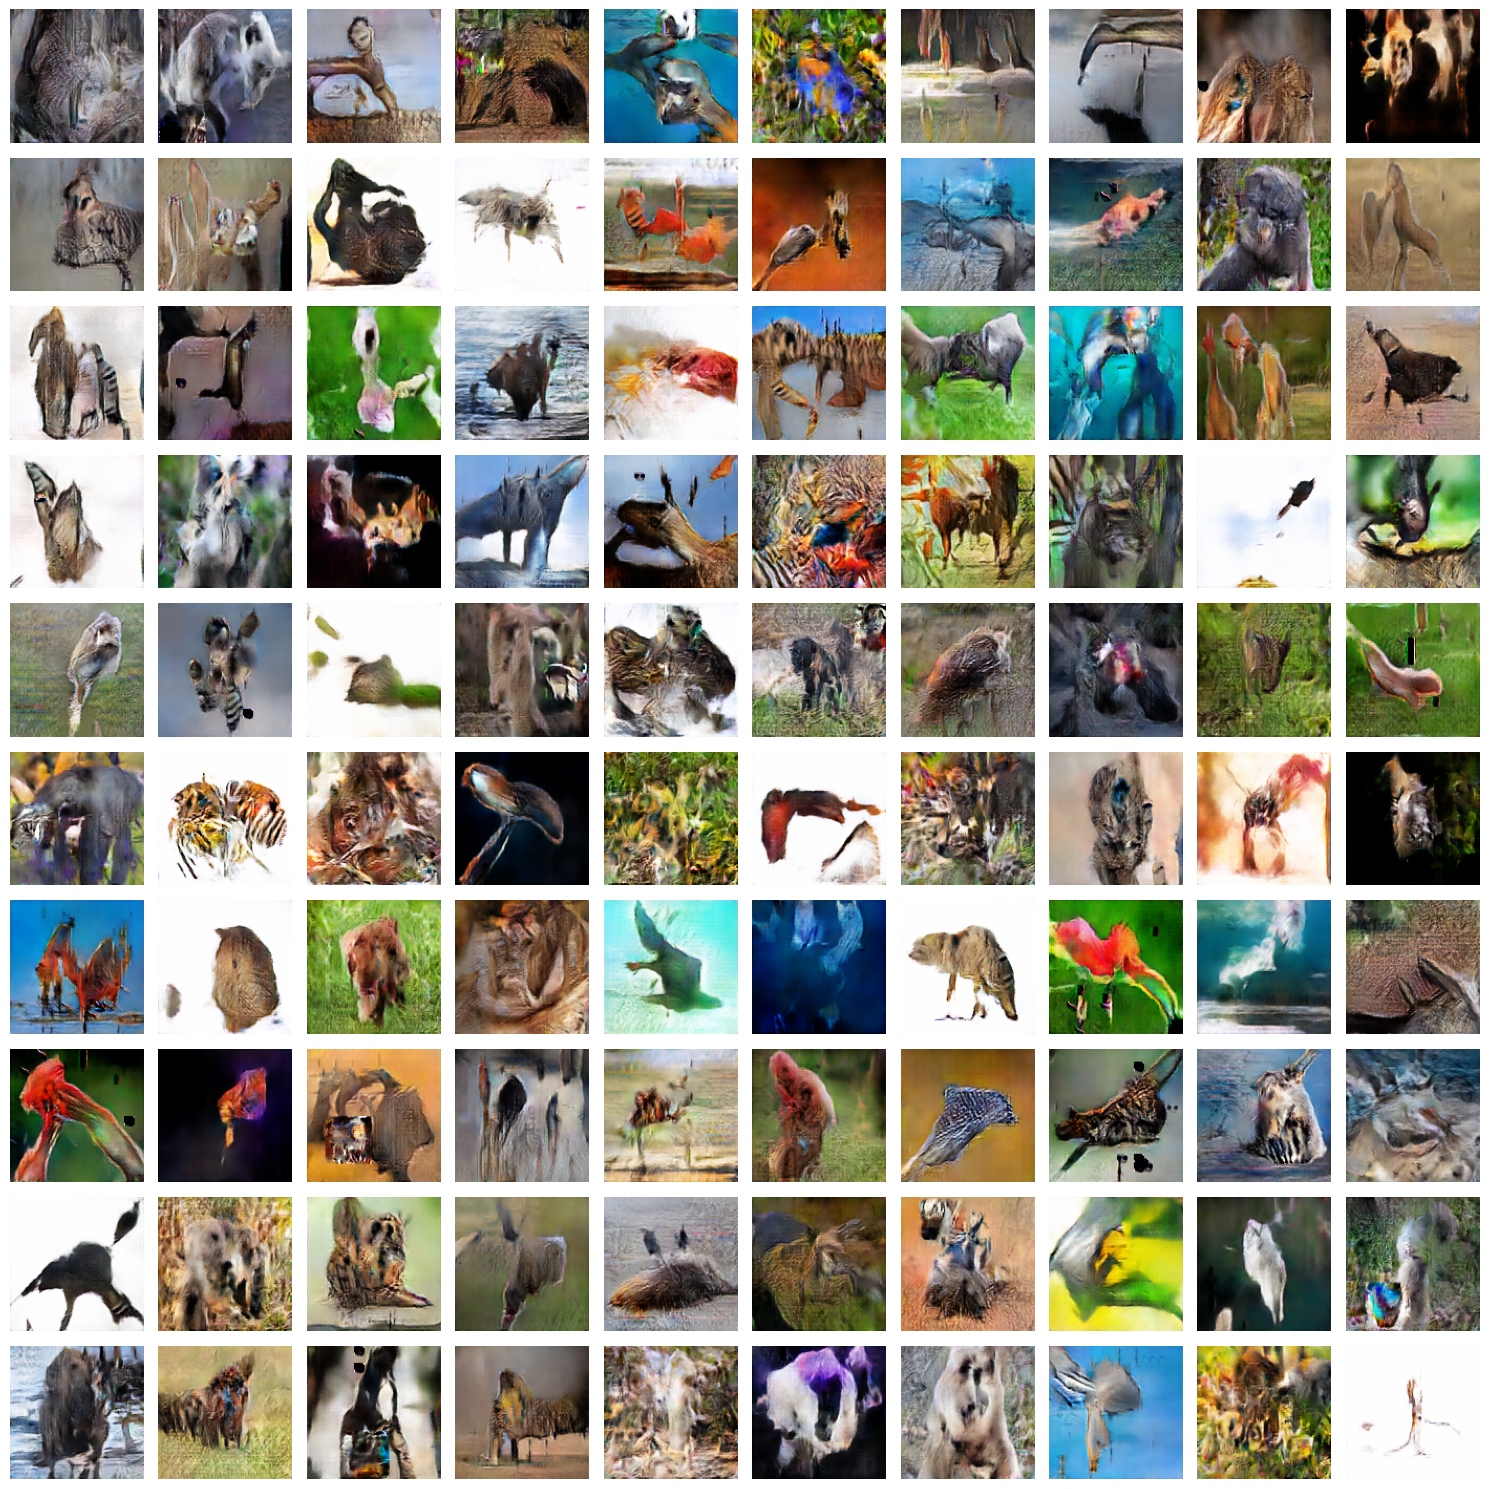